# Exercises

In [1]:
import numpy as np
from scipy import stats
from scipy import ndimage
import matplotlib.pyplot as plt
import pickle
import sys
from tqdm import tqdm
import os
sys.path.append(os.path.abspath("code"))

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


In [2]:
def simu_cell(space_bins=np.arange(0., 200., 5.), noise_firing_rate=0.1,
              progress_bar=True, n_cells = 100, pf_size=None, pf_rate=None):

    np.random.seed(4242) # fix random seed for reproducibility

    track_length = 200.
    average_firing_rate = 5
    pf_centers = np.random.rand(n_cells) * track_length
    if pf_size is None:
        pf_size = np.random.gamma(10, size=n_cells)
    if pf_rate is None:
        pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells)

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

    n_runs = 20 
    av_running_speed = 10
    fps = 30
    running_speed_a = np.random.chisquare(10, size=n_runs)
    running_speed_b = np.random.chisquare(10, size=n_runs) 
    stopping_time_a = np.random.chisquare(15, size=n_runs)
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps

    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    if progress_bar:
        for i in tqdm(range(n_cells)):
            inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
            spikes_loc = np.random.poisson(inst_rate/sampling_rate)
            sp = np.argwhere(spikes_loc)
            t_sp = t_sampling[sp]
            spikes.append(t_sp)
    else:
        for i in range(n_cells):
            inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
            spikes_loc = np.random.poisson(inst_rate/sampling_rate)
            sp = np.argwhere(spikes_loc)
            t_sp = t_sampling[sp]
            spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy
    
    return firing_rate_maps, pf_centers, spike_positions, occupancy

**A - Change the binning**

In [111]:
space_bins = [np.arange(0., 200., 5.), np.arange(0., 200., 2.), np.arange(0., 200., 10.)]
maps_a = []
for bins in space_bins:
    firing_rate_maps, _, _, _ = simu_cell(space_bins=bins)
    maps_a.append(firing_rate_maps)

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


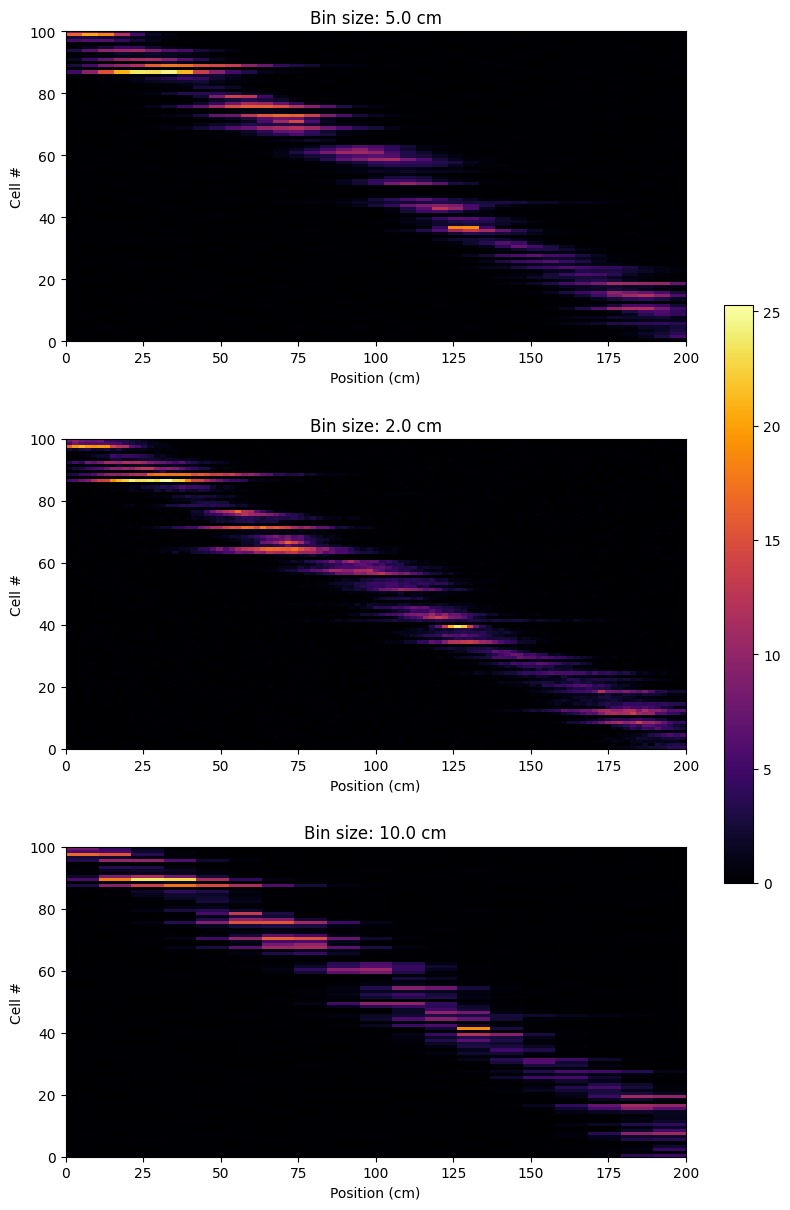

In [112]:
min_a = np.min([np.min(m) for m in maps_a])
max_a = np.max([np.max(m) for m in maps_a])
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, firing_rate_maps in enumerate(maps_a):
    n_cells = firing_rate_maps.shape[0]
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    im = axes[i].imshow(firing_rate_maps[ix,:], cmap='inferno', extent=[0, 200, 0, n_cells], vmin=min_a, vmax=max_a)
    axes[i].set_xlabel('Position (cm)')
    axes[i].set_ylabel('Cell #')
    axes[i].set_title('Bin size: {} cm'.format(space_bins[i][1]-space_bins[i][0]))
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.5)
plt.show()

**B - Change the noise level**

In [5]:
noise_firing_rates = [0.1, 1, 5.]
maps_b = []
for noise_firing_rate in noise_firing_rates:
    firing_rate_maps, _, _, _ = simu_cell(noise_firing_rate=noise_firing_rate)
    maps_b.append(firing_rate_maps)

100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


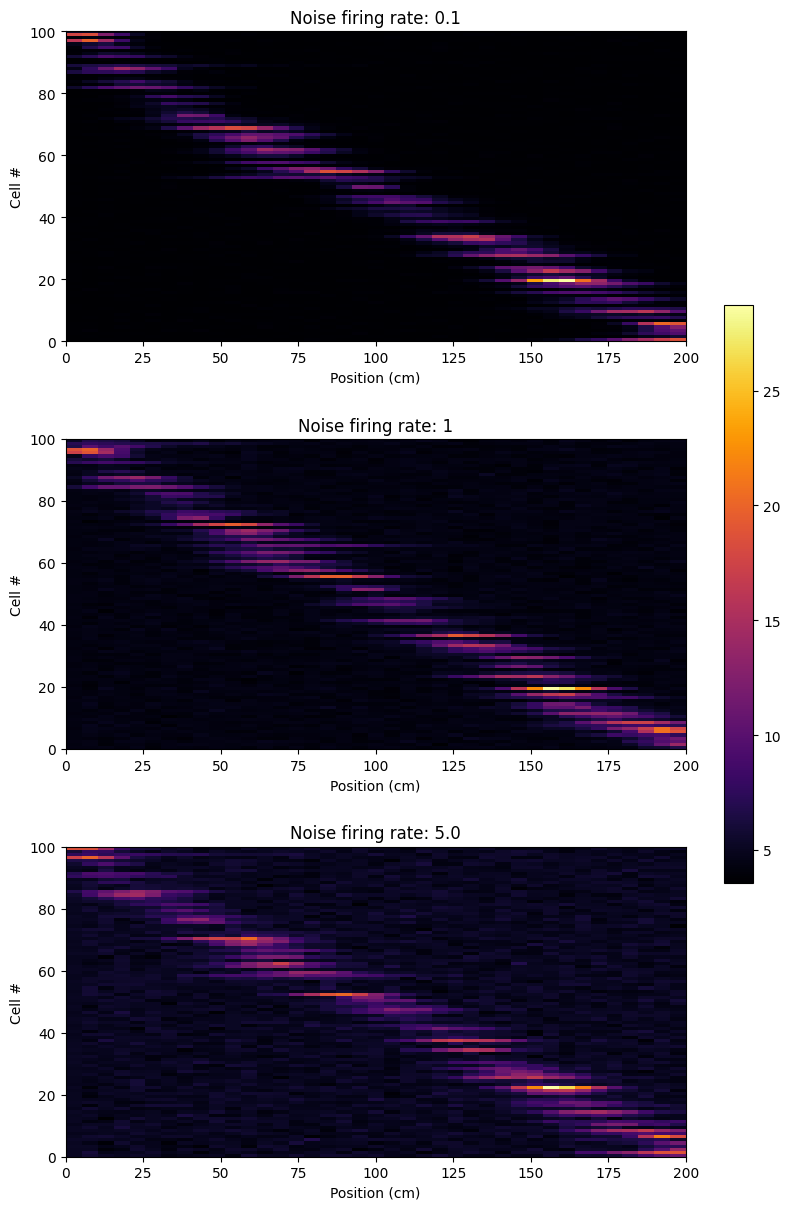

In [19]:
min_b = np.min([np.min(m) for m in maps_b])
max_b = np.max([np.max(m) for m in maps_b])
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, firing_rate_maps in enumerate(maps_b):
    n_cells = firing_rate_maps.shape[0]
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    im = axes[i].imshow(firing_rate_maps[ix,:], cmap='inferno', extent=[0, 200, 0, n_cells], vmin=min_b, vmax=max_b)
    axes[i].set_xlabel('Position (cm)')
    axes[i].set_ylabel('Cell #')
    axes[i].set_title('Noise firing rate: {}'.format(noise_firing_rates[i]))
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.5)
plt.show()

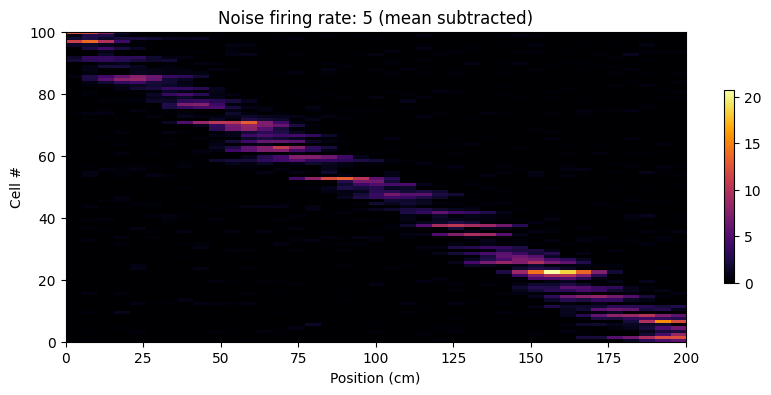

In [7]:
# For firing rate map with high noise, it might be helpful to subtract the mean firing rate
# Take the example of the firing rate map with noise_firing_rate = 5
rate_map_noisy = maps_b[2] - maps_b[2].mean(axis=1)[:, np.newaxis]
rate_map_noisy[rate_map_noisy<0] = 0

# Plot the tuning curve with a color bar
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
n_cells = rate_map_noisy.shape[0]
peak_locations = rate_map_noisy.argmax(axis=1)
ix = np.argsort(peak_locations)
im = ax.imshow(rate_map_noisy[ix,:], cmap='inferno', extent=[0, 200, 0, n_cells], vmin=min_b, vmax=max_b)
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Cell #')
ax.set_title('Noise firing rate: 5 (mean subtracted)')
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.5)
plt.show()

**C - Apply a Gaussian smoother to the firing rate maps**


In [8]:
space_bins = np.arange(0., 200., 1.)
noise_firing_rates = [0.1, 1, 5.]
maps_c = []
for noise_firing_rate in noise_firing_rates:
    firing_rate_maps, _, _, _ = simu_cell(space_bins=space_bins, noise_firing_rate=noise_firing_rate)
    maps_c.append(firing_rate_maps)

100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


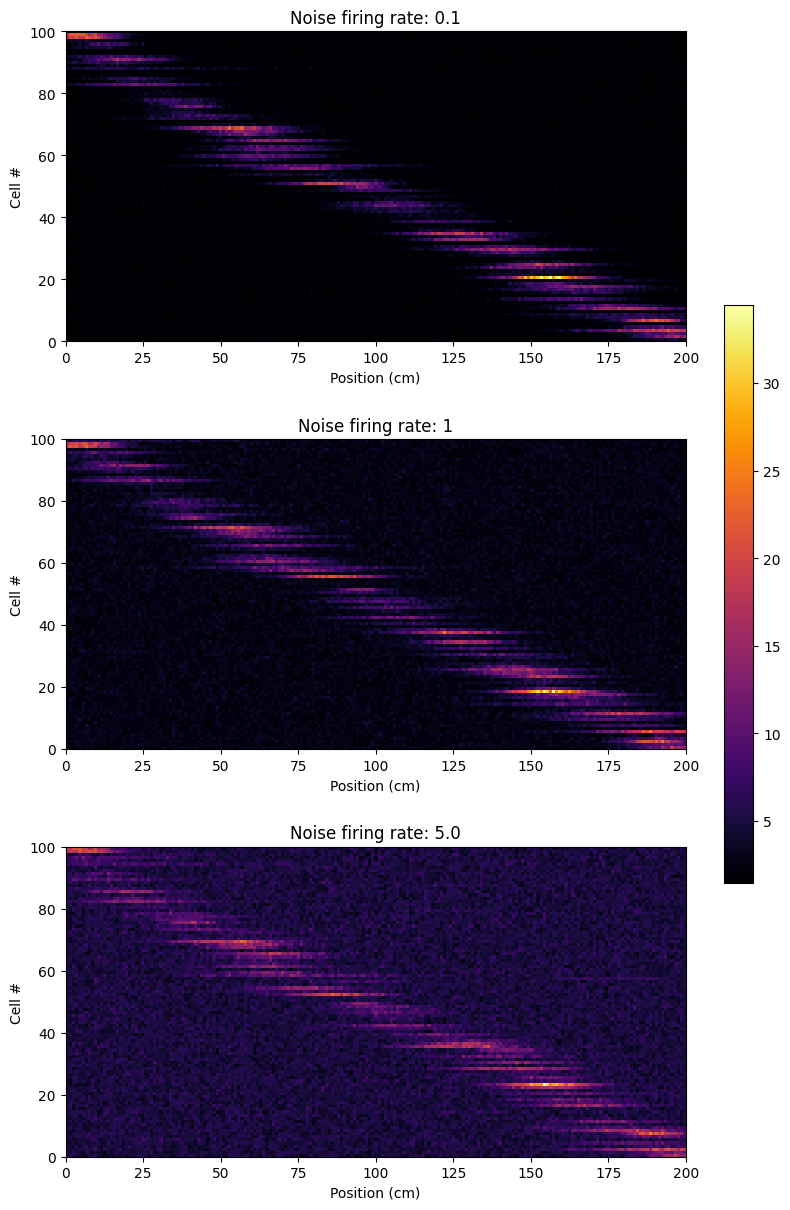

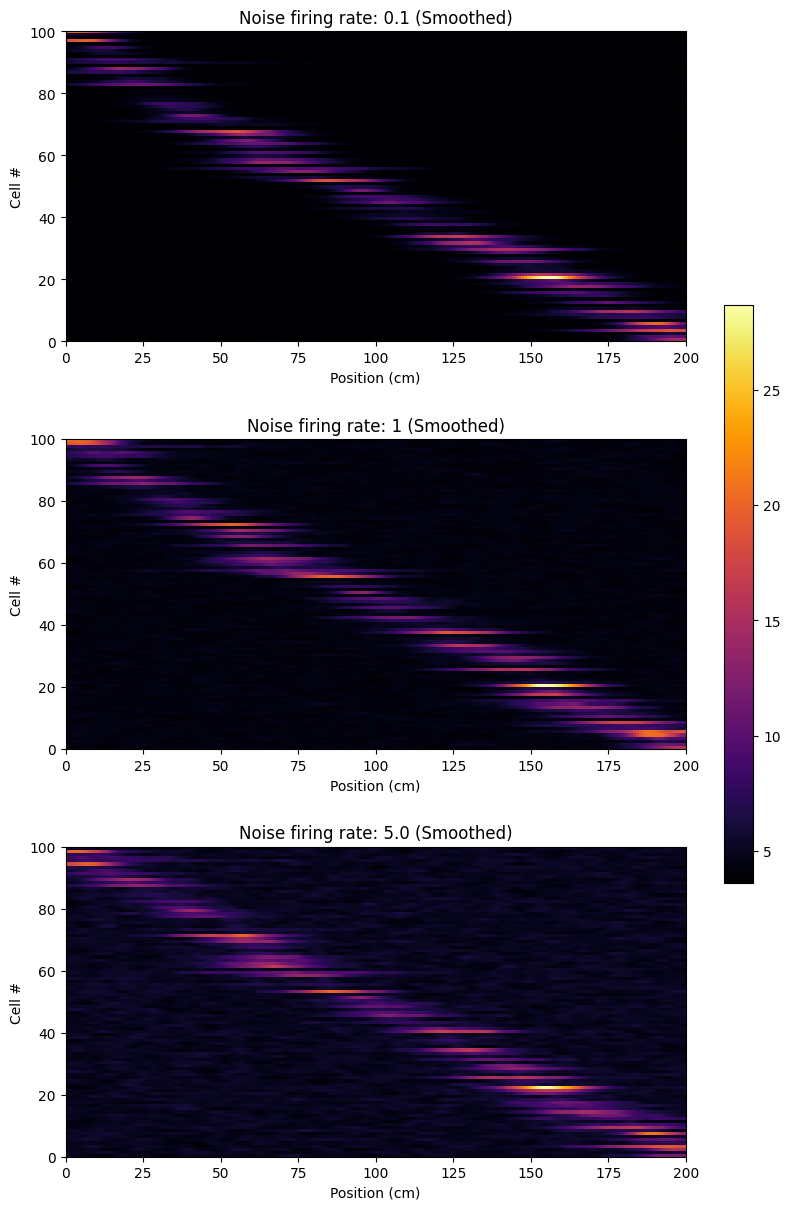

In [9]:
# Apply the Gaussian smoother
maps_c_smooth = np.zeros_like(maps_c)
for i, firing_rate_maps in enumerate(maps_c):
    n_cells = firing_rate_maps.shape[0]
    for j in range(n_cells):
        # stats.gaussian_kde does not work well (gives me an almost all-zero flat kernel); so use ndimage.gaussian_filter1d instead
        # kde = stats.gaussian_kde(firing_rate_maps[j,:])
        # maps_c_smooth[i,j,:] = kde.evaluate(space_bins[:-1])
        maps_c_smooth[i,j,:] = ndimage.gaussian_filter1d(firing_rate_maps[j,:], sigma=2)

min_c = np.min([np.min(m) for m in maps_c])
max_c = np.max([np.max(m) for m in maps_c])

# Plot the tuning curves with a common color scale
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, firing_rate_maps in enumerate(maps_c):
    n_cells = firing_rate_maps.shape[0]
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    im = axes[i].imshow(firing_rate_maps[ix,:], cmap='inferno', extent=[0, 200, 0, n_cells], vmin=min_c, vmax=max_c)
    axes[i].set_xlabel('Position (cm)')
    axes[i].set_ylabel('Cell #')
    axes[i].set_title('Noise firing rate: {}'.format(noise_firing_rates[i]))
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.5)
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
for i, firing_rate_maps in enumerate(maps_c_smooth):
    n_cells = firing_rate_maps.shape[0]
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    im = axes[i].imshow(firing_rate_maps[ix,:], cmap='inferno', extent=[0, 200, 0, n_cells])
    axes[i].set_xlabel('Position (cm)')
    axes[i].set_ylabel('Cell #')
    axes[i].set_title('Noise firing rate: {} (Smoothed)'.format(noise_firing_rates[i]))
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.5)
plt.show()

**D - Calculate the place field center**

In [3]:
def get_pf_center(spike_positions):
    return np.mean(spike_positions)

noise = 0.1
maps, true_pf_centers, spike_positions, _ = simu_cell(noise_firing_rate=noise)
comp_pf_centers = [get_pf_center(spike_pos) for spike_pos in spike_positions]

errors = np.abs(np.array(true_pf_centers) - np.array(comp_pf_centers))

100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


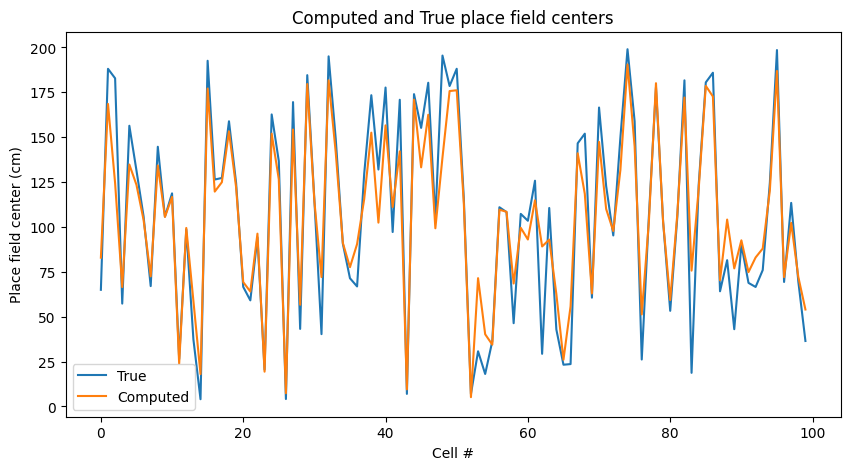

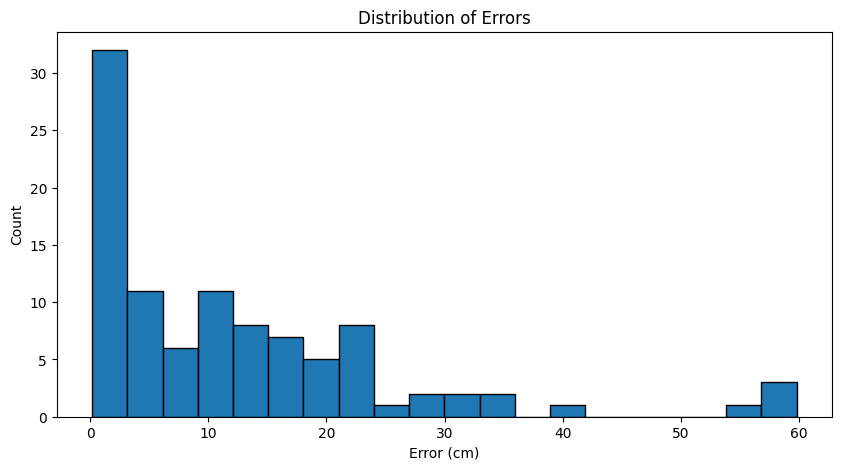

In [13]:
# Plot the true and computed place field centers
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(true_pf_centers, label='True')
ax.plot(comp_pf_centers, label='Computed')
ax.set_xlabel('Cell #')
ax.set_ylabel('Place field center (cm)')
ax.set_title('Computed and True place field centers')
ax.legend()
plt.show()

# Plot the error histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(errors, bins=20, edgecolor='k')
ax.set_xlabel('Error (cm)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Errors')
plt.show()

<div class="alert alert-block alert-info">

**Report for Exercise 1**

A. As the bin size decreases, the plot looks more smoother; if the bin size increase, te plot becomes more discrete.

B. The `noise_firing_rate` variable determines the noise level in simulation. As the noise level goes up, the plot looks more "smeared", meaning that there are more colored bins beyond the peak position. <br>
When the firing rate map has high-level noise, it might be helpful to subtract the mean firing rate from the data, and set any negative value after subtraction to 0. As the experiment shows, the subtraction gives a clear firing rate mate and preserve the shave of tuning curves.

C. The suggested function `scipy.stats.gaussian_kde` does not work well for me, so I used `scipy.ndimage.gaussian_filter1d` instead. When the noise level is high, the Gaussian smoothing helps suppress the noise outside the surrounding of the peak position.

D. The "true" place field center is recorded in the variable named `pf_centers`. The calculated PF centers are reasonably close to the true values, despite some errors.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

**A - Implement the mutual information formula**

In [12]:
# Simulate the data
maps, _, _, occ = simu_cell()

100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


In [16]:
# Implement the mutual information formula
def mutual_info(firing_rate_maps, occupancy, epsilon=1e-10):
    all_mi = []
    for i in range(firing_rate_maps.shape[0]):
        mi = np.nansum(occupancy * firing_rate_maps[i,:] * np.log2((firing_rate_maps[i,:]+epsilon) / np.mean(firing_rate_maps[i,:])))
        all_mi.append(mi)
    return np.array(all_mi)

def mutual_info_2(firing_rate_maps, occupancy, epsilon=1e-10):
    I = mutual_info(firing_rate_maps, occupancy, epsilon=epsilon)
    return I / np.mean(I)

In [14]:
# Apply the mutual information formula
mi = mutual_info(maps, occ)
mi_2 = mutual_info_2(maps, occ)

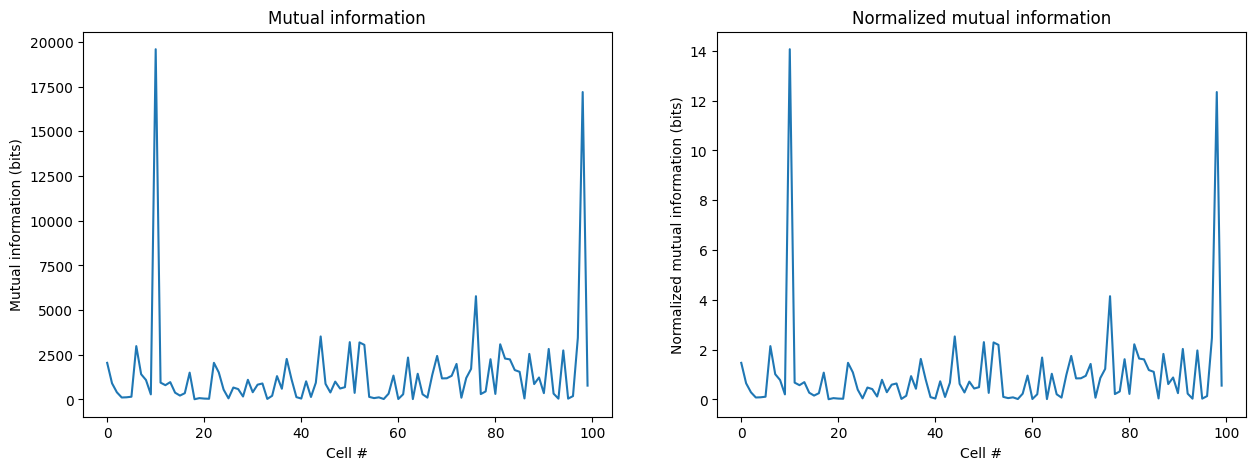

In [15]:
# Plot the mutual information
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(mi)
ax[0].set_xlabel('Cell #')
ax[0].set_ylabel('Mutual information (bits)')
ax[0].set_title('Mutual information')
ax[1].plot(mi_2)
ax[1].set_xlabel('Cell #')
ax[1].set_ylabel('Normalized mutual information (bits)')
ax[1].set_title('Normalized mutual information')
plt.show()

**B - Dependency of mutual information on simulation parameters**

In [26]:
pf_rates = np.linspace(1, 20, 20)
pf_sizes = np.linspace(1, 20, 20)
noises = np.linspace(0.1, 5, 20)
mi_rates = []
mi_rates_2 = []
mi_sizes = []
mi_sizes_2 = []
mi_noise = []
mi_noise_2 = []

for rate in tqdm(pf_rates):
    maps, _, _, occ = simu_cell(progress_bar=False, n_cells = 1, pf_rate=[rate])
    mi_rates.append(mutual_info(maps, occ))
    mi_rates_2.append(mutual_info_2(maps, occ))
for size in tqdm(pf_sizes):
    maps, _, _, occ = simu_cell(progress_bar=False, n_cells = 1, pf_size=[size])
    mi_sizes.append(mutual_info(maps, occ))
    mi_sizes_2.append(mutual_info_2(maps, occ))
for noise in tqdm(noises):
    maps, _, _, occ = simu_cell(progress_bar=False, n_cells = 1, noise_firing_rate=[noise])
    mi_noise.append(mutual_info(maps, occ))
    mi_noise_2.append(mutual_info_2(maps, occ))

100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


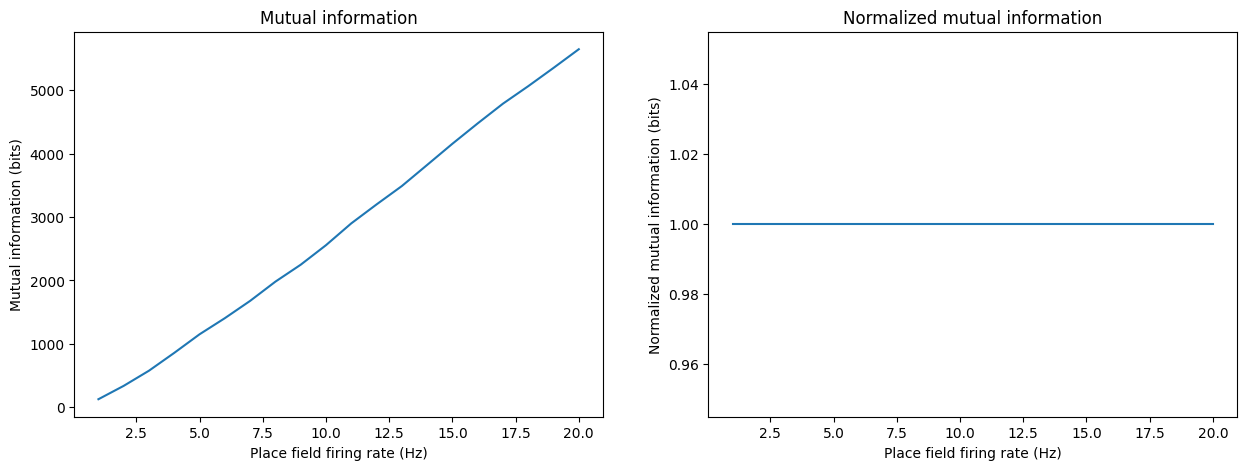

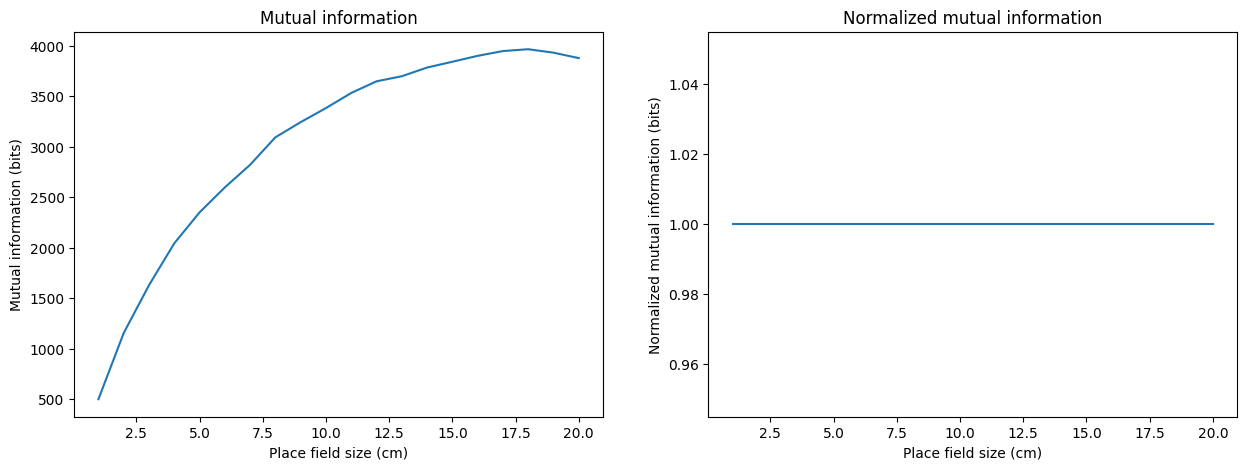

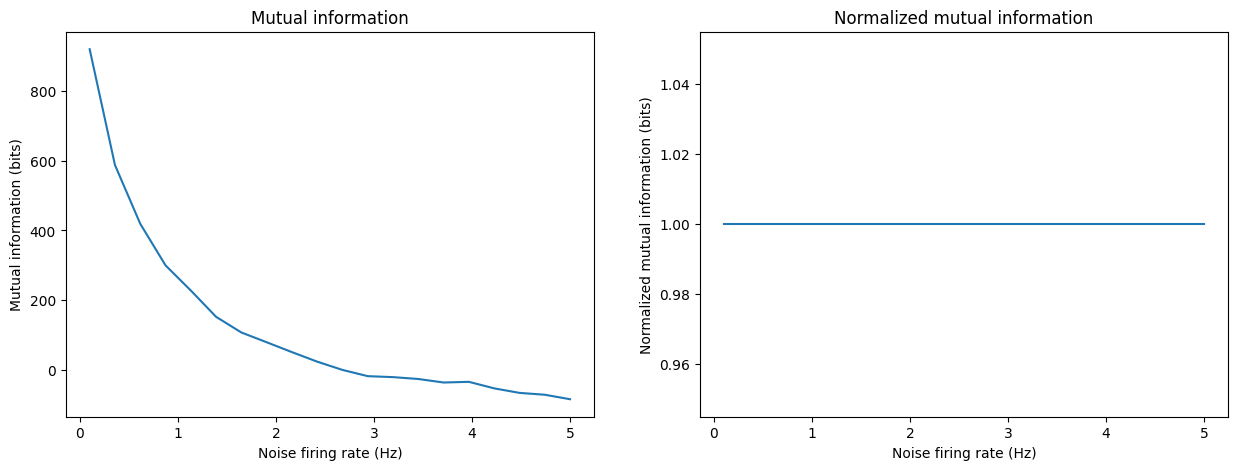

In [27]:
# Plot the mutual information as a function of the place field firing rate
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(pf_rates, mi_rates)
ax[0].set_xlabel('Place field firing rate (Hz)')
ax[0].set_ylabel('Mutual information (bits)')
ax[0].set_title('Mutual information')
ax[1].plot(pf_rates, mi_rates_2)
ax[1].set_xlabel('Place field firing rate (Hz)')
ax[1].set_ylabel('Normalized mutual information (bits)')
ax[1].set_title('Normalized mutual information')
plt.show()

# Plot the mutual information as a function of the place field size
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(pf_sizes, mi_sizes)
ax[0].set_xlabel('Place field size (cm)')
ax[0].set_ylabel('Mutual information (bits)')
ax[0].set_title('Mutual information')
ax[1].plot(pf_sizes, mi_sizes_2)
ax[1].set_xlabel('Place field size (cm)')
ax[1].set_ylabel('Normalized mutual information (bits)')
ax[1].set_title('Normalized mutual information')
plt.show()

# Plot the mutual information as a function of the noise firing rate
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(noises, mi_noise)
ax[0].set_xlabel('Noise firing rate (Hz)')
ax[0].set_ylabel('Mutual information (bits)')
ax[0].set_title('Mutual information')
ax[1].plot(noises, mi_noise_2)
ax[1].set_xlabel('Noise firing rate (Hz)')
ax[1].set_ylabel('Normalized mutual information (bits)')
ax[1].set_title('Normalized mutual information')
plt.show()

<div class="alert alert-block alert-info">

**Report for Exercise 2**

A. Please check the above code for implementation and results.

B. For the regular mutual information formula (first definition), the amount of mutual information increases with peak firing rate (linear) and place field size (non-linear concave). This makes sense because as the firing rate and PF size increase, the cell could tell more information about the stimuli. The amount of mutual information decreases with noise level (non linear convex), probably because the noise does not carry information.

For the normalized mutual information formula (second definition), the amount of mutual information does not change with any of these parameters. This might mean that the normalized mutual information emphasizes on the intrinsic property of the cell and stimuli, independent of the place field properties or outside noise.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualize the position as a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak position.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [115]:
#import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']
t = data['t']
spikes = data['spikes']

**A - Visualize the position as a function of time. Plot the spike of a selected cell in space.**

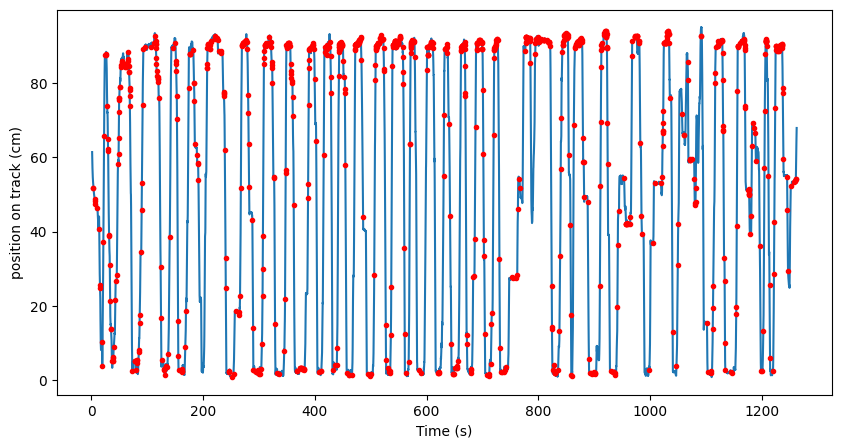

In [116]:
plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

cell = 9
plt.plot(spikes[cell], np.interp(spikes[cell], t, x), 'r.')
plt.show()

**B - Calculate and plot the firing rate maps for all the cells**

In [117]:
space_bins = np.arange(0., np.max(x), 2.)
spike_positions = [np.interp(s, t, x) for s in spikes]
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.vstack(spikes_hist).astype(np.float64)
fps = 30
occupancy = np.histogram(x, space_bins)[0] / fps
firing_rate_maps = spikes_hist / occupancy

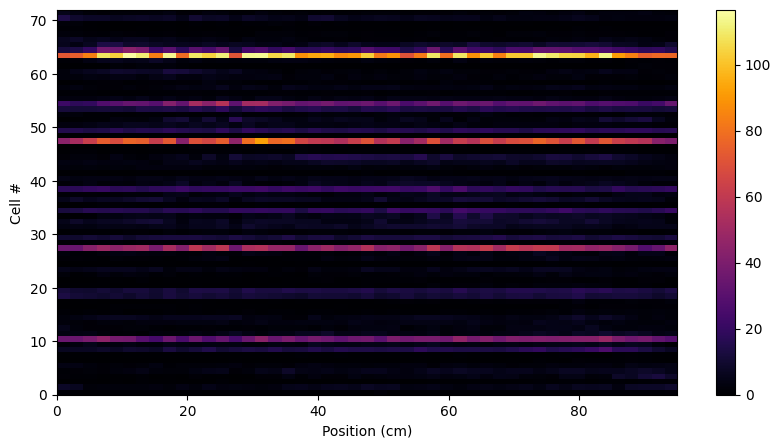

In [118]:
n_cells = len(spikes)
peak_locations = np.argmax(firing_rate_maps, axis=1)

# # gaussian smoothing
# sigma = 2
# firing_rate_maps = ndimage.gaussian_filter1d(firing_rate_maps, sigma=sigma, axis=1)

plt.figure(figsize=(10,5))
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent=[0, np.max(x), 0, n_cells], aspect='auto')
plt.xlabel('Position (cm)')
plt.ylabel('Cell #')
plt.colorbar()
plt.show()

**C - Compute mutual information**

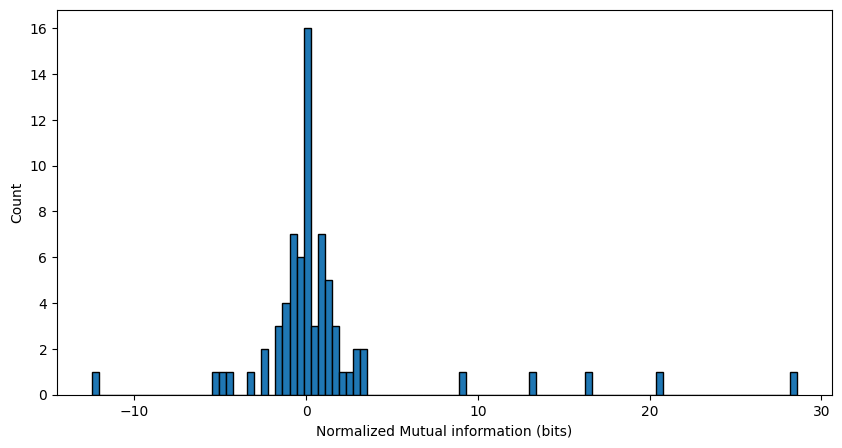

In [119]:
mi = mutual_info(firing_rate_maps, occupancy)
mi_2 = mutual_info_2(firing_rate_maps, occupancy)

# Plot the distribution of mutual information
plt.figure(figsize=(10,5))
plt.hist(mi_2, bins=100, edgecolor = 'black')
plt.xlabel('Normalized Mutual information (bits)')
plt.ylabel('Count')
plt.show()

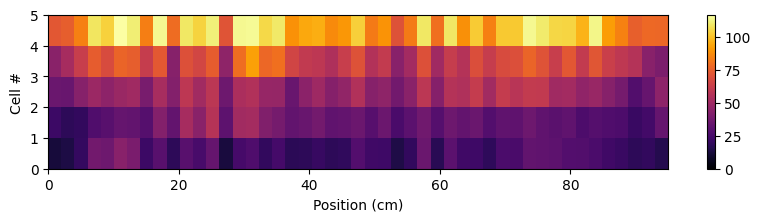

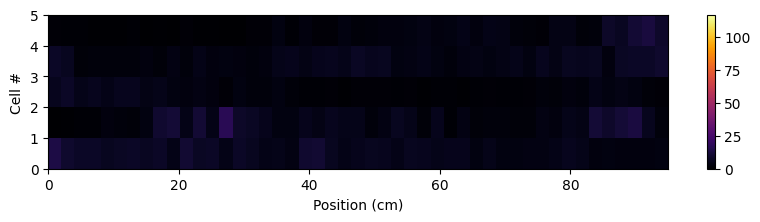

In [121]:
min = np.min(firing_rate_maps)
max = np.max(firing_rate_maps)

# Top 5 cells with the highest mutual information
ix = np.argsort(mi_2)[::-1]
plt.figure(figsize=(10,2))
plt.imshow(firing_rate_maps[ix[:5],:], cmap='inferno', extent=[0, np.max(x), 0, 5], aspect='auto', vmin=min, vmax=max)
plt.xlabel('Position (cm)')
plt.ylabel('Cell #')
plt.colorbar()
plt.show()

# Last 5 cells with the lowest mutual information
ix = np.argsort(mi_2)
plt.figure(figsize=(10,2))
plt.imshow(firing_rate_maps[ix[:5],:], cmap='inferno', extent=[0, np.max(x), 0, 5], aspect='auto', vmin=min, vmax=max)
plt.xlabel('Position (cm)')
plt.ylabel('Cell #')
plt.colorbar()
plt.show()

<div class="alert alert-block alert-info">

**Report for Exercise 3**

A & B. Please check the above code for implementation and results.

C. The cells which have higher level of mutual information also have higher firing rates. The cells with lower mutual information level are likely to have lower firing rates. This may suggest that higher firing rate could carry more spatial information.